<a href="https://colab.research.google.com/github/jnardosp/foldwalker/blob/main/hp_model_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Parte 1:** Convertir una cadena de aminoácidos a un lattice 3D

## Hydrophobic - Polar Lattice Model MonteCarlo sampling

Let's perform an initial MCMC sampling on a HP model to later do approximate counting of proteins.

Aminoacids & H (Hydrophobic) - P (Polar/Neutral) Classification:
| Aminoacid     | Letter | H or P |
|---------------|--------|--------|
| Alanine       | A      | H      |
| Arginine      | R      | P      |
| Asparagine    | N      | P      |
| Aspartate     | D      | P      |
| Cysteine      | C      | H      |
| Glutamine     | Q      | P      |
| Glutamate     | E      | P      |
| Glycine       | G      | P      |
| Histidine     | H      | P      |
| Isoleucine    | I      | H      |
| Leucine       | L      | H      |
| Lysine        | K      | P      |
| Methionine    | M      | H      |
| Phenylalanine | F      | H      |
| Proline       | P      | P      |
| Serine        | S      | P      |
| Threonine     | T      | P      |
| Tryptophan    | W      | H      |
| Tyrosine      | Y      | H      |
| Valine        | V      | H      |

[Aminoacids & HP](https://www.alfa-chemistry.com/resources/hydrophobicity-index-table-of-common-amino-acids.html)


In [10]:
import plotly.graph_objects as go
import numpy as np
from typing import List, Tuple, Optional

In [11]:
# HP classification mapping
HP_MAP = {
    'A': 'H', 'C': 'H', 'I': 'H', 'L': 'H', 'M': 'H',
    'F': 'H', 'W': 'H', 'Y': 'H', 'V': 'H',
    'R': 'P', 'N': 'P', 'D': 'P', 'Q': 'P', 'E': 'P',
    'G': 'P', 'H': 'P', 'K': 'P', 'P': 'P', 'S': 'P', 'T': 'P'
}

def generate_linear_chain(sequence: str) -> Tuple[List[Tuple[int, int, int]], List[str]]:
    """
    Generate a linear chain along the x-axis (simpler than random SAW).
    
    This provides a better starting point for MCMC than a random SAW.
    """
    coords = []
    hp_types = []
    
    for i, aa in enumerate(sequence):
        coords.append((i, 0, 0))
        hp_types.append(HP_MAP.get(aa, 'P'))
    
    return coords, hp_types

def plot_hp_lattice_3d(sequence, coords, hp_types):
    """Plot 3D HP lattice using Plotly."""
    # Separate H and P residues
    h_coords = [coords[i] for i, hp in enumerate(hp_types) if hp == 'H']
    p_coords = [coords[i] for i, hp in enumerate(hp_types) if hp == 'P']

    # Create figure
    fig = go.Figure()

    # Add hydrophobic residues (H) as red spheres
    if h_coords:
        h_x, h_y, h_z = zip(*h_coords)
        fig.add_trace(go.Scatter3d(
            x=h_x, y=h_y, z=h_z,
            mode='markers',
            marker=dict(size=12, color='red'),
            name='Hydrophobic (H)',
            text=[f'Residue {i+1}: {sequence[i]} (H)'
                  for i, hp in enumerate(hp_types) if hp == 'H']
        ))

    # Add polar residues (P) as blue spheres
    if p_coords:
        p_x, p_y, p_z = zip(*p_coords)
        fig.add_trace(go.Scatter3d(
            x=p_x, y=p_y, z=p_z,
            mode='markers',
            marker=dict(size=10, color='blue', opacity=0.8),
            name='Polar (P)',
            text=[f'Residue {i+1}: {sequence[i]} (P)'
                  for i, hp in enumerate(hp_types) if hp == 'P']
        ))

    # Add connections between residues
    x_coords, y_coords, z_coords = zip(*coords)
    fig.add_trace(go.Scatter3d(
        x=x_coords, y=y_coords, z=z_coords,
        mode='lines',
        line=dict(color='gray', width=4),
        name='Protein Backbone'
    ))

    # Update layout
    fig.update_layout(
        title=f'3D HP Lattice Model: {sequence}',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        showlegend=True
    )

    fig.show()

    # Print statistics
    print(f"Sequence: {sequence}")
    print(f"Length: {len(sequence)} residues")
    print(f"H residues: {hp_types.count('H')}")
    print(f"P residues: {hp_types.count('P')}")
    print(f"Unique positions: {len(set(coords))}")

# Example usage
if __name__ == "__main__":
    # Test sequence - you can replace with your own
    test_sequence = "ACDEFGHIKLMNPQRSTVWY"

    coords, hp_types = generate_linear_chain(test_sequence)
    print("Coords: ", coords)
    print("HP_types: ", hp_types)

    # Generate and plot
    plot_hp_lattice_3d(test_sequence, coords, hp_types)

Coords:  [(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0), (6, 0, 0), (7, 0, 0), (8, 0, 0), (9, 0, 0), (10, 0, 0), (11, 0, 0), (12, 0, 0), (13, 0, 0), (14, 0, 0), (15, 0, 0), (16, 0, 0), (17, 0, 0), (18, 0, 0), (19, 0, 0)]
HP_types:  ['H', 'H', 'P', 'P', 'H', 'P', 'P', 'H', 'P', 'H', 'H', 'P', 'P', 'P', 'P', 'P', 'P', 'H', 'H', 'H']


Sequence: ACDEFGHIKLMNPQRSTVWY
Length: 20 residues
H residues: 9
P residues: 11
Unique positions: 20


## **Parte 2:** calcular la función de energía de un lattice 3D

In [12]:
import numpy as np
from itertools import combinations
from typing import Sequence, Union, Callable, Tuple, List, Dict, Optional

def _default_U(a: str, b: str) -> float:
    """Interacción por defecto: -1 si ambos H, 0 en otro caso (modelo HP)."""
    return -1.0 if a.upper() == 'H' and b.upper() == 'H' else 0.0

def energy_hp(coords: Union[np.ndarray, Sequence[Sequence[float]]],
              seq: Union[str, Sequence[str]],
              U: Optional[Union[Callable[[str,str], float], Dict[str, Dict[str, float]]]] = None,
              contact_distance: float = 1.0,
              tol: float = 1e-8,
              metric: str = 'euclidean',
              return_contacts: bool = False
              ) -> Union[float, Tuple[float, List[Tuple[int,int,float]]]]:
    """
    Calcula la energía E_HP(C) = sum_{i=0}^{N-3} sum_{j=i+2}^{N-1} U(h_i,h_j) * C_ij,
    donde C_ij = 1 si i y j son vecinos más cercanos en la retícula (distancia == contact_distance),
    y U(h_i,h_j) es la potencial de interacción (por defecto: -1 si ambos 'H', 0 en otro caso).

    Parámetros:
    - coords: array-like (N,3) con coordenadas de cada residuo (enteras o floats).
    - seq: secuencia de tipos (ej. "HHPHP" o ['H','P',...]).
    - U: función U(a,b)->float o dict-of-dicts U[a][b]; si None usa el modelo HP por defecto.
    - contact_distance: distancia que define vecinos (por defecto 1.0).
    - tol: tolerancia numérica para comparar distancias.
    - metric: 'euclidean' (por defecto) o 'manhattan'.
    - return_contacts: si True, devuelve además lista de (i,j,contribución).

    Devuelve:
    - energía (float), o (energía, contactos) si return_contacts=True.
    """
    coords = np.asarray(coords, dtype=float)
    if coords.ndim != 2 or coords.shape[1] != 3:
        raise ValueError("coords debe ser array de forma (N,3)")
    N = coords.shape[0]
    if isinstance(seq, str):
        seq_list = list(seq.upper())
    else:
        seq_list = [str(s).upper() for s in seq]
    if len(seq_list) != N:
        raise ValueError("La longitud de seq debe coincidir con el número de coordenadas")

    # normalizar U a una función callable
    if U is None:
        Ucall = _default_U
    elif callable(U):
        Ucall = U
    elif isinstance(U, dict):
        def Ucall(a,b):
            a = a.upper(); b = b.upper()
            # intentar dict-of-dicts con simetría si es necesario
            if a in U and b in U[a]:
                return float(U[a][b])
            if b in U and a in U[b]:
                return float(U[b][a])
            # intentar clave tuple (a,b)
            if (a,b) in U:
                return float(U[(a,b)])
            if (b,a) in U:
                return float(U[(b,a)])
            # fallback
            return 0.0
    else:
        raise ValueError("U debe ser None, callable o dict-of-dicts")

    E = 0.0
    contacts: List[Tuple[int,int,float]] = []

    # Iterar sobre pares i<j con |i-j| >= 2 (i=0..N-3, j=i+2..N-1)
    for i, j in combinations(range(N), 2):
        if abs(i - j) < 2:
            continue  # saltar pares consecutivos
        diff = coords[i] - coords[j]
        if metric == 'euclidean':
            d = np.linalg.norm(diff)
            is_contact = abs(d - contact_distance) <= tol
        elif metric == 'manhattan':
            d = np.sum(np.abs(diff))
            is_contact = abs(d - contact_distance) <= tol
        else:
            raise ValueError("metric debe ser 'euclidean' o 'manhattan'")

        if is_contact:
            contrib = float(Ucall(seq_list[i], seq_list[j]))
            if contrib != 0.0:
                E += contrib
            # guardamos el contacto y la contribución (incluso si 0) para debug
            contacts.append((i, j, contrib))

    if return_contacts:
        return E, contacts
    return E

In [13]:
# Tests simples
coords1 = [(0,0,0),(1,0,0),(2,0,0),(3,0,0)]
seq1 = "HHHH"
print("Lineal (sin contactos):", energy_hp(coords1, seq1))  # 0

coords2 = [(0,0,0),(1,0,0),(1,1,0),(0,1,0)]
seq2 = "HHHH"
print("i=0,j=3 contacto:", energy_hp(coords2, seq2))  # -1

coords3 = [(0,0,0),(1,0,0),(2,0,0),(2,1,0),(1,1,0),(0,1,0)]
seq3 = "HHHHHH"
print("i=0,j=5 contacto y i=1,j=4 contacto:", energy_hp(coords3, seq3))  # -2

coords3 = [(0,0,0),(1,0,0),(2,0,0),(2,1,0),(1,1,0),(0,1,0)]
seq3 = "HHHHHP"
print("i=1,j=4 contacto:", energy_hp(coords3, seq3))  # -1

Lineal (sin contactos): 0.0
i=0,j=3 contacto: -1.0
i=0,j=5 contacto y i=1,j=4 contacto: -2.0
i=1,j=4 contacto: -1.0


In [14]:
# Para debugging: devolver índices de los contactos y contribución de cada uno
coords3 = [(0,0,0),(1,0,0),(2,0,0),(2,1,0),(1,1,0),(0,1,0)]
seq3 = "HHHHHH"
print("i=0,j=5 contacto y i=1,j=4 contacto:", energy_hp(coords3, seq3, return_contacts=True))  # -2

i=0,j=5 contacto y i=1,j=4 contacto: (-2.0, [(0, 5, -1.0), (1, 4, -1.0)])


## **Parte 3**: MonteCarlo Moves

In [15]:
import numpy as np
import random
from typing import List, Tuple, Optional

def check_self_avoiding(coords: List[Tuple[int, int, int]]) -> bool:
    """
    Check if the chain is self-avoiding (no duplicate positions).
    """
    return len(set(coords)) == len(coords)

def check_chain_connectivity(coords: List[Tuple[int, int, int]]) -> bool:
    """
    Check if the chain maintains connectivity (adjacent residues are lattice neighbors).
    """
    for i in range(len(coords) - 1):
        dx = abs(coords[i][0] - coords[i+1][0])
        dy = abs(coords[i][1] - coords[i+1][1])
        dz = abs(coords[i][2] - coords[i+1][2])
        
        # Adjacent residues should differ by exactly 1 in one coordinate
        if dx + dy + dz != 1:
            return False
    return True

def end_move(coords: List[Tuple[int, int, int]], hp_types: List[str]) -> Tuple[List[Tuple[int, int, int]], bool]:
    """
    Move an end residue to a new position.
    
    This is the simplest Monte Carlo move: take the first or last residue and move it
    to a new position adjacent to its bonded neighbor, while maintaining self-avoidance.
    
    Args:
        coords: Current coordinates of the chain
        hp_types: List of 'H' or 'P' for each residue
        
    Returns:
        new_coords: New coordinates after move (or unchanged if move fails)
        success: Boolean indicating if move was successful
    """
    n = len(coords)
    if n < 2:
        return coords, False
    
    # Choose which end to move (0 = N-terminus, n-1 = C-terminus)
    end_idx = random.choice([0, n-1])
    
    # Get the bonded neighbor
    neighbor_idx = 1 if end_idx == 0 else n-2
    current_pos = coords[end_idx]
    neighbor_pos = coords[neighbor_idx]
    
    # All possible lattice directions
    directions = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
    
    # Find all valid positions adjacent to the neighbor
    valid_positions = []
    for dx, dy, dz in directions:
        candidate = (neighbor_pos[0] + dx, neighbor_pos[1] + dy, neighbor_pos[2] + dz)
        
        # Check if position is unoccupied and different from current position
        if candidate != current_pos and candidate not in coords:
            valid_positions.append(candidate)
    
    if not valid_positions:
        return coords, False
    
    # Choose a random valid position
    new_pos = random.choice(valid_positions)
    
    # Create new coordinates
    new_coords = coords.copy()
    new_coords[end_idx] = new_pos
    
    # Verify the move maintains self-avoidance
    if not check_self_avoiding(new_coords):
        return coords, False
    
    return new_coords, True

def crankshaft_move(coords: List[Tuple[int, int, int]], hp_types: List[str]) -> Tuple[List[Tuple[int, int, int]], bool]:
    """
    Perform a crankshaft (corner flip) move.
    
    This move identifies a 3-residue L-shaped segment (i, i+1, i+2) and rotates
    the middle residue to the other possible position that maintains connectivity.
    
    Args:
        coords: Current coordinates of the chain
        hp_types: List of 'H' or 'P' for each residue
        
    Returns:
        new_coords: New coordinates after move (or unchanged if move fails)
        success: Boolean indicating if move was successful
    """
    n = len(coords)
    if n < 3:
        return coords, False
    
    # Find all valid 3-residue segments that form an L-shape (90-degree turn)
    valid_segments = []
    
    for i in range(n - 2):
        p0 = coords[i]
        p1 = coords[i+1]
        p2 = coords[i+2]
        
        # Check if this forms an L-shape (two perpendicular unit vectors)
        v1 = (p1[0] - p0[0], p1[1] - p0[1], p1[2] - p0[2])
        v2 = (p2[0] - p1[0], p2[1] - p1[1], p2[2] - p1[2])
        
        # Both vectors should be unit lattice vectors
        if sum(abs(x) for x in v1) != 1 or sum(abs(x) for x in v2) != 1:
            continue
            
        # Vectors should be perpendicular (dot product = 0)
        dot = v1[0]*v2[0] + v1[1]*v2[1] + v1[2]*v2[2]
        if dot == 0:
            valid_segments.append(i)
    
    if not valid_segments:
        return coords, False
    
    # Randomly choose a valid segment
    i = random.choice(valid_segments)
    
    p0 = coords[i]
    p1 = coords[i+1]
    p2 = coords[i+2]
    
    # Calculate the two vectors
    v1 = (p1[0] - p0[0], p1[1] - p0[1], p1[2] - p0[2])
    v2 = (p2[0] - p1[0], p2[1] - p1[1], p2[2] - p1[2])
    
    # The new position for p1 is: p0 + v2 (going from p0 in direction of v2)
    # OR equivalently: p2 + v1 (going from p2 in direction of v1)
    new_p1 = (p0[0] + v2[0], p0[1] + v2[1], p0[2] + v2[2])
    
    # Alternative: new_p1 = (p2[0] + v1[0], p2[1] + v1[1], p2[2] + v1[2])
    # Both should give the same result for a proper L-shape
    
    # Check if the new position is unoccupied
    # We need to check all positions except the current p1
    occupied = set(coords[:i+1] + coords[i+2:])
    
    if new_p1 in occupied:
        return coords, False
    
    # Create new coordinates
    new_coords = coords.copy()
    new_coords[i+1] = new_p1
    
    return new_coords, True

def pivot_move(coords: List[Tuple[int, int, int]], hp_types: List[str]) -> Tuple[List[Tuple[int, int, int]], bool]:
    """
    Pivot move: Choose a pivot point and rotate one part of the chain.
    
    This is a more global move that can dramatically change conformation.
    We randomly choose a pivot residue and rotate the tail (everything after pivot)
    by 90 or 180 degrees around an axis.
    
    Args:
        coords: Current coordinates of the chain
        hp_types: List of 'H' or 'P' for each residue
        
    Returns:
        new_coords: New coordinates after move (or unchanged if move fails)
        success: Boolean indicating if move was successful
    """
    n = len(coords)
    if n < 3:
        return coords, False
    
    # Choose a pivot point (not at the very end)
    pivot_idx = random.randint(1, n-2)
    
    # Choose rotation: 90 or 180 degrees around x, y, or z axis
    # Rotation matrices for 90 degree rotations in 3D lattice
    rotations = [
        # 90° around x-axis
        lambda x, y, z: (x, -z, y),
        # 90° around y-axis
        lambda x, y, z: (z, y, -x),
        # 90° around z-axis
        lambda x, y, z: (-y, x, z),
        # 180° around x-axis
        lambda x, y, z: (x, -y, -z),
        # 180° around y-axis
        lambda x, y, z: (-x, y, -z),
        # 180° around z-axis
        lambda x, y, z: (-x, -y, z)
    ]
    
    rot_func = random.choice(rotations)
    
    # Get pivot coordinates
    pivot = coords[pivot_idx]
    
    # Rotate the tail (residues after pivot)
    new_coords = coords.copy()
    for i in range(pivot_idx + 1, n):
        # Translate to origin, rotate, translate back
        dx = coords[i][0] - pivot[0]
        dy = coords[i][1] - pivot[1]
        dz = coords[i][2] - pivot[2]
        
        rx, ry, rz = rot_func(dx, dy, dz)
        new_pos = (pivot[0] + rx, pivot[1] + ry, pivot[2] + rz)
        
        # Check if this position is already occupied (except by residues we're moving)
        # We need to check all occupied positions except those in the tail we're rotating
        occupied_positions = set(coords[:pivot_idx + 1])  # Fixed part of chain
        
        if new_pos in occupied_positions:
            return coords, False  # Collision detected
        
        new_coords[i] = new_pos
    
    # Final check: ensure entire chain is self-avoiding
    if not check_self_avoiding(new_coords):
        return coords, False
    
    return new_coords, True

def mcmc_move(coords: List[Tuple[int, int, int]], hp_types: List[str], 
              move_type: str = 'random') -> Tuple[List[Tuple[int, int, int]], bool]:
    """
    Perform a Monte Carlo move of specified type.
    
    Args:
        coords: Current coordinates
        hp_types: List of 'H' or 'P' for each residue
        move_type: 'end', 'crankshaft', 'pivot', or 'random' (randomly choose)
        
    Returns:
        new_coords: New coordinates after move
        success: Boolean indicating if move was successful
    """
    if move_type == 'random':
        move_type = random.choice(['end', 'crankshaft', 'pivot'])
    
    if move_type == 'end':
        return end_move(coords, hp_types)
    elif move_type == 'crankshaft':
        return crankshaft_move(coords, hp_types)
    elif move_type == 'pivot':
        return pivot_move(coords, hp_types)
    else:
        raise ValueError(f"Unknown move type: {move_type}")

# Test the moves
if __name__ == "__main__":
    HP_MAP = {
        'A': 'H', 'C': 'H', 'I': 'H', 'L': 'H', 'M': 'H',
        'F': 'H', 'W': 'H', 'Y': 'H', 'V': 'H',
        'R': 'P', 'N': 'P', 'D': 'P', 'Q': 'P', 'E': 'P',
        'G': 'P', 'H': 'P', 'K': 'P', 'P': 'P', 'S': 'P', 'T': 'P'
    }
    
    # Test with a short sequence
    test_sequence = "ACDEFG"
    print(f"Test sequence: {test_sequence}")
    print(f"HP mapping: {[HP_MAP.get(aa, 'P') for aa in test_sequence]}")
    
    # Generate linear chain
    coords, hp_types = generate_linear_chain(test_sequence)
    print(f"\nInitial linear chain coordinates: {coords}")
    print(f"Self-avoiding: {check_self_avoiding(coords)}")
    print(f"Chain connectivity: {check_chain_connectivity(coords)}")
    
    # Test end move
    new_coords, success = end_move(coords, hp_types)
    print(f"\nEnd move success: {success}")
    if success:
        print(f"New coordinates: {new_coords}")
        print(f"Self-avoiding: {check_self_avoiding(new_coords)}")
        plot_hp_lattice_3d(test_sequence, new_coords, hp_types)
    
    # Test corner flip (will likely fail on linear chain - needs a corner)
    new_coords2, success2 = crankshaft_move(coords, hp_types)
    print(f"\nCorner flip success (on linear chain): {success2}")
    
    # Create a chain with a corner manually for testing
    coords_with_corner = [(0,0,0), (1,0,0), (1,1,0), (1,1,1)]
    hp_types_corner = ['H', 'P', 'H', 'P']
    new_coords3, success3 = crankshaft_move(coords_with_corner, hp_types_corner)
    print(f"\nCorner flip success (on chain with corner): {success3}")
    if success3:
        print(f"Original: {coords_with_corner}")
        plot_hp_lattice_3d("HPHP", coords_with_corner, hp_types_corner)
        print(f"New: {new_coords3}")
        plot_hp_lattice_3d("HPHP", new_coords3, hp_types_corner)
    
    # Test pivot move
    new_coords4, success4 = pivot_move(coords, hp_types)
    print(f"\nPivot move success: {success4}")
    if success4:
        print(f"Original: {coords}")
        plot_hp_lattice_3d(test_sequence, coords, hp_types)
        print(f"New: {new_coords4}")
        plot_hp_lattice_3d(test_sequence, new_coords4, hp_types)

Test sequence: ACDEFG
HP mapping: ['H', 'H', 'P', 'P', 'H', 'P']

Initial linear chain coordinates: [(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0)]
Self-avoiding: True
Chain connectivity: True

End move success: True
New coordinates: [(1, 0, -1), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0)]
Self-avoiding: True


Sequence: ACDEFG
Length: 6 residues
H residues: 3
P residues: 3
Unique positions: 6

Corner flip success (on linear chain): False

Corner flip success (on chain with corner): True
Original: [(0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)]


Sequence: HPHP
Length: 4 residues
H residues: 2
P residues: 2
Unique positions: 4
New: [(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 1, 1)]


Sequence: HPHP
Length: 4 residues
H residues: 2
P residues: 2
Unique positions: 4

Pivot move success: True
Original: [(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0)]


Sequence: ACDEFG
Length: 6 residues
H residues: 3
P residues: 3
Unique positions: 6
New: [(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0)]


Sequence: ACDEFG
Length: 6 residues
H residues: 3
P residues: 3
Unique positions: 6


## **Parte 4:** MCMC & Simulated Annealing

Initial energy: 0.00
Starting MCMC sampling:
  Sequence: MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKIELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK
  Length: 162 residues
  Initial energy: 0.00
  Temperature: 1.0
  Total steps: 5000
  Move probabilities: {'end': 0.5, 'crankshaft': 0.3, 'pivot': 0.2}

Step 1000/5000:
  Current energy: -12.00
  Best energy: -12.00
  Overall acceptance rate: 79.10%
Step 2000/5000:
  Current energy: -19.00
  Best energy: -25.00
  Overall acceptance rate: 71.80%
Step 3000/5000:
  Current energy: -12.00
  Best energy: -25.00
  Overall acceptance rate: 72.90%
Step 4000/5000:
  Current energy: -20.00
  Best energy: -25.00
  Overall acceptance rate: 72.55%
Step 5000/5000:
  Current energy: -15.00
  Best energy: -25.00
  Overall acceptance rate: 70.88%

MCMC Sampling Complete!
Best energy found: -25.00
Final energy: -15.00

Acceptance rates by move type:
  end         : 87.29% (2191/2510 acc

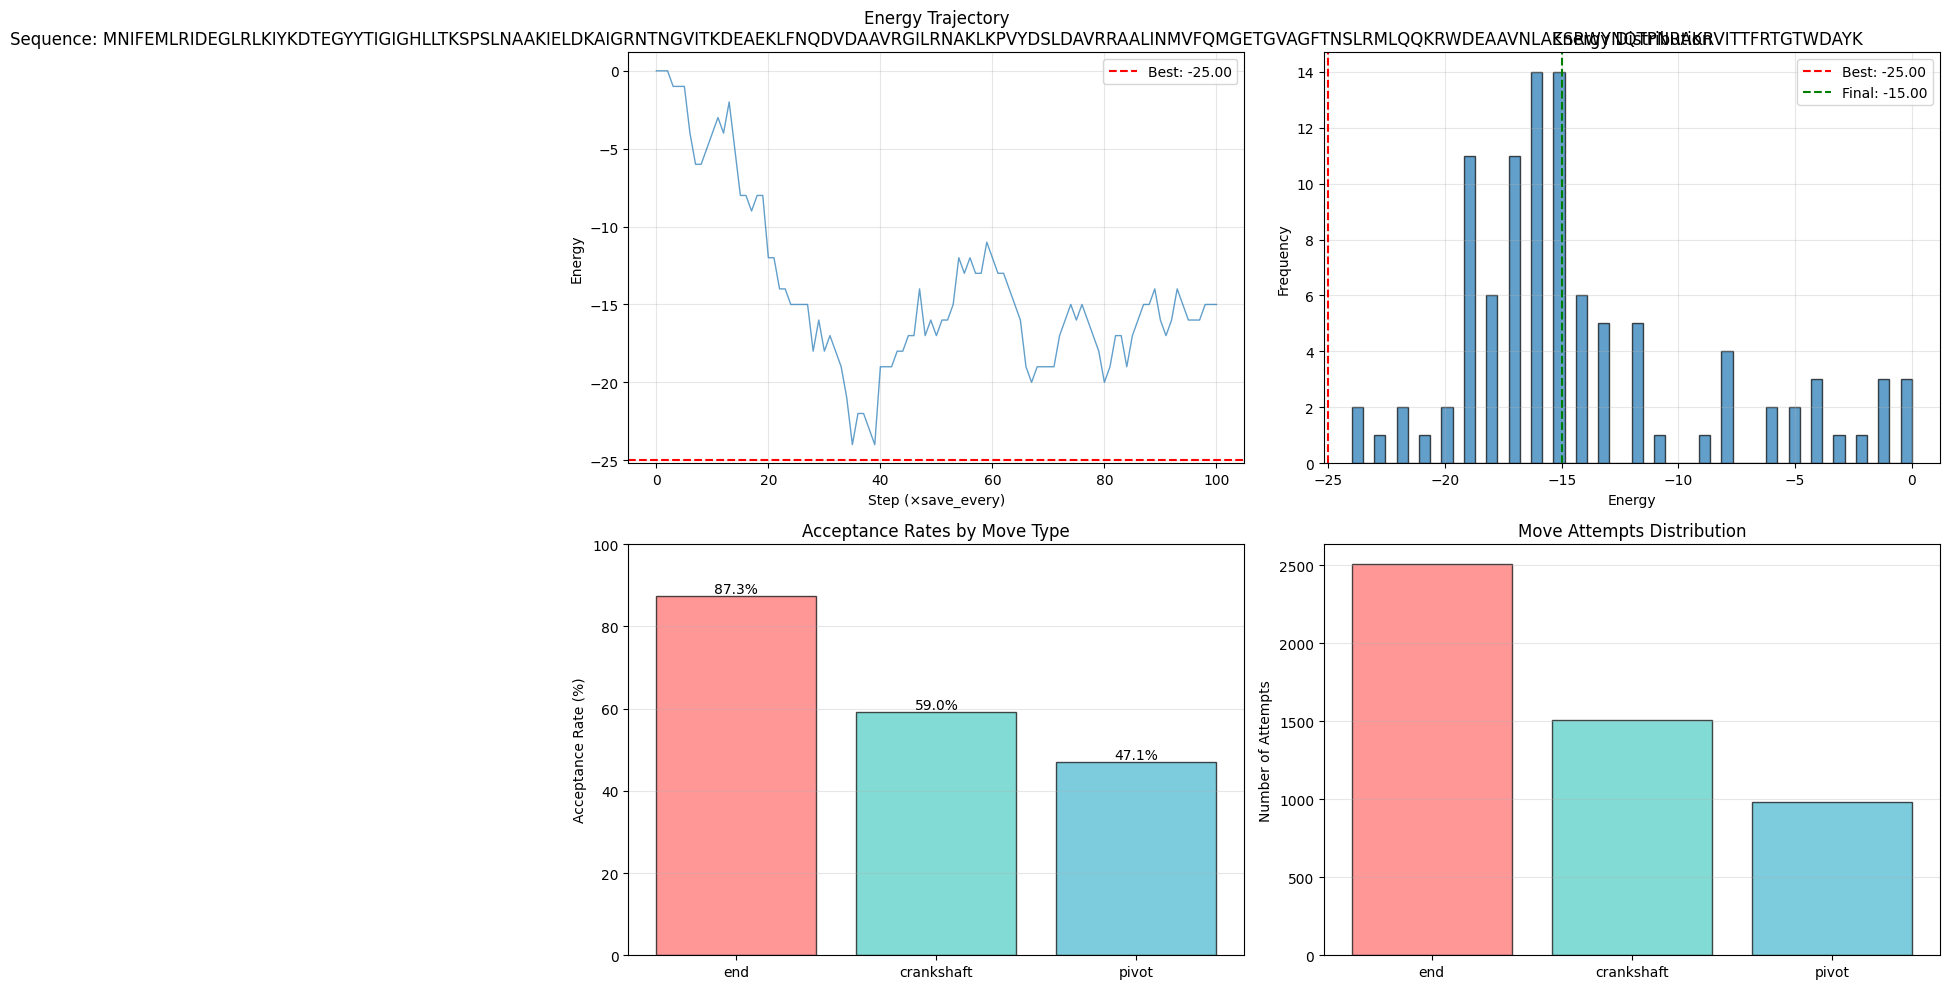


Best structure found:


Sequence: MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKIELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK
Length: 162 residues
H residues: 70
P residues: 92
Unique positions: 162


In [19]:
import numpy as np
import random
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
from collections import defaultdict

def metropolis_acceptance(energy_old: float, energy_new: float, temperature: float) -> bool:
    """
    Metropolis acceptance criterion.
    
    Accept the new state if:
    - Energy decreases (ΔE < 0): always accept
    - Energy increases (ΔE > 0): accept with probability exp(-ΔE/kT)
    
    Args:
        energy_old: Energy of current state
        energy_new: Energy of proposed new state
        temperature: Temperature parameter (kT)
        
    Returns:
        True if move should be accepted, False otherwise
    """
    delta_E = energy_new - energy_old
    
    # Always accept if energy decreases
    if delta_E <= 0:
        return True
    
    # Accept with probability exp(-ΔE/kT) if energy increases
    acceptance_prob = np.exp(-delta_E / temperature)
    return random.random() < acceptance_prob


def mcmc_sampling(
    sequence: str,
    initial_coords: List[Tuple[int, int, int]],
    hp_types: List[str],
    n_steps: int = 10000,
    temperature: float = 1.0,
    move_probabilities: Optional[Dict[str, float]] = None,
    save_every: int = 100,
    verbose: bool = True
) -> Dict:
    """
    Perform MCMC sampling on HP lattice model using Metropolis criterion.
    
    Args:
        sequence: Amino acid sequence string
        initial_coords: Starting coordinates
        hp_types: List of 'H' or 'P' for each residue
        n_steps: Number of MCMC steps to perform
        temperature: Temperature for Metropolis criterion (higher = more exploration)
        move_probabilities: Dict with probabilities for each move type
                           e.g., {'end': 0.4, 'crankshaft': 0.3, 'pivot': 0.3}
        save_every: Save trajectory every N steps
        verbose: Print progress information
        
    Returns:
        Dictionary containing:
        - 'best_coords': Coordinates with lowest energy found
        - 'best_energy': Lowest energy found
        - 'final_coords': Final coordinates
        - 'final_energy': Final energy
        - 'energy_trajectory': List of energies at saved steps
        - 'coords_trajectory': List of coordinates at saved steps
        - 'acceptance_rates': Dict of acceptance rates per move type
        - 'move_counts': Dict of attempted moves per type
    """
    # Default move probabilities
    if move_probabilities is None:
        move_probabilities = {
            'end': 0.5,
            'crankshaft': 0.3,
            'pivot': 0.2
        }
    
    # Normalize probabilities
    total = sum(move_probabilities.values())
    move_probabilities = {k: v/total for k, v in move_probabilities.items()}
    
    # Initialize tracking variables
    current_coords = initial_coords.copy()
    current_energy = energy_hp(current_coords, hp_types)
    
    best_coords = current_coords.copy()
    best_energy = current_energy
    
    energy_trajectory = [current_energy]
    coords_trajectory = [current_coords.copy()]
    
    # Track move statistics
    move_attempts = defaultdict(int)
    move_acceptances = defaultdict(int)
    
    if verbose:
        print(f"Starting MCMC sampling:")
        print(f"  Sequence: {sequence}")
        print(f"  Length: {len(sequence)} residues")
        print(f"  Initial energy: {current_energy:.2f}")
        print(f"  Temperature: {temperature}")
        print(f"  Total steps: {n_steps}")
        print(f"  Move probabilities: {move_probabilities}")
        print()
    
    # Main MCMC loop
    for step in range(n_steps):
        # Choose move type based on probabilities
        move_type = random.choices(
            list(move_probabilities.keys()),
            weights=list(move_probabilities.values())
        )[0]
        
        # Attempt the move
        new_coords, success = mcmc_move(current_coords, hp_types, move_type)
        move_attempts[move_type] += 1
        
        if not success:
            # Move failed (collision or invalid), stay at current state
            if (step + 1) % save_every == 0:
                energy_trajectory.append(current_energy)
                coords_trajectory.append(current_coords.copy())
            continue
        
        # Calculate new energy
        new_energy = energy_hp(new_coords, hp_types)
        
        # Metropolis acceptance
        if metropolis_acceptance(current_energy, new_energy, temperature):
            # Accept the move
            current_coords = new_coords
            current_energy = new_energy
            move_acceptances[move_type] += 1
            
            # Update best if this is the lowest energy
            if current_energy < best_energy:
                best_coords = current_coords.copy()
                best_energy = current_energy
                if verbose and step % 1000 == 0:
                    print(f"Step {step}: New best energy = {best_energy:.2f}")
        
        # Save trajectory
        if (step + 1) % save_every == 0:
            energy_trajectory.append(current_energy)
            coords_trajectory.append(current_coords.copy())
            
            if verbose and (step + 1) % 1000 == 0:
                acceptance_rate = sum(move_acceptances.values()) / sum(move_attempts.values())
                print(f"Step {step + 1}/{n_steps}:")
                print(f"  Current energy: {current_energy:.2f}")
                print(f"  Best energy: {best_energy:.2f}")
                print(f"  Overall acceptance rate: {acceptance_rate:.2%}")
    
    # Calculate acceptance rates
    acceptance_rates = {}
    for move_type in move_probabilities.keys():
        if move_attempts[move_type] > 0:
            acceptance_rates[move_type] = move_acceptances[move_type] / move_attempts[move_type]
        else:
            acceptance_rates[move_type] = 0.0
    
    if verbose:
        print("\n" + "="*60)
        print("MCMC Sampling Complete!")
        print("="*60)
        print(f"Best energy found: {best_energy:.2f}")
        print(f"Final energy: {current_energy:.2f}")
        print(f"\nAcceptance rates by move type:")
        for move_type, rate in acceptance_rates.items():
            attempts = move_attempts[move_type]
            print(f"  {move_type:12s}: {rate:6.2%} ({move_acceptances[move_type]}/{attempts} accepted)")
        print()
    
    return {
        'best_coords': best_coords,
        'best_energy': best_energy,
        'final_coords': current_coords,
        'final_energy': current_energy,
        'energy_trajectory': energy_trajectory,
        'coords_trajectory': coords_trajectory,
        'acceptance_rates': acceptance_rates,
        'move_counts': dict(move_attempts),
        'move_acceptances': dict(move_acceptances)
    }


def plot_mcmc_results(results: Dict, sequence: str):
    """
    Plot MCMC results: energy trajectory and acceptance rates.
    
    Args:
        results: Dictionary returned by mcmc_sampling
        sequence: Amino acid sequence string
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Energy trajectory
    ax = axes[0, 0]
    energy_traj = results['energy_trajectory']
    ax.plot(energy_traj, linewidth=1, alpha=0.7)
    ax.axhline(y=results['best_energy'], color='r', linestyle='--', 
               label=f'Best: {results["best_energy"]:.2f}')
    ax.set_xlabel('Step (×save_every)')
    ax.set_ylabel('Energy')
    ax.set_title(f'Energy Trajectory\nSequence: {sequence}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Energy histogram
    ax = axes[0, 1]
    ax.hist(energy_traj, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(x=results['best_energy'], color='r', linestyle='--', 
               label=f'Best: {results["best_energy"]:.2f}')
    ax.axvline(x=results['final_energy'], color='g', linestyle='--',
               label=f'Final: {results["final_energy"]:.2f}')
    ax.set_xlabel('Energy')
    ax.set_ylabel('Frequency')
    ax.set_title('Energy Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Acceptance rates
    ax = axes[1, 0]
    move_types = list(results['acceptance_rates'].keys())
    rates = [results['acceptance_rates'][mt] * 100 for mt in move_types]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars = ax.bar(move_types, rates, color=colors[:len(move_types)], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Acceptance Rate (%)')
    ax.set_title('Acceptance Rates by Move Type')
    ax.set_ylim([0, 100])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Plot 4: Move attempts distribution
    ax = axes[1, 1]
    move_counts = [results['move_counts'][mt] for mt in move_types]
    ax.bar(move_types, move_counts, color=colors[:len(move_types)], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Number of Attempts')
    ax.set_title('Move Attempts Distribution')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


def simulated_annealing(
    sequence: str,
    initial_coords: List[Tuple[int, int, int]],
    hp_types: List[str],
    n_steps: int = 10000,
    T_initial: float = 2.0,
    T_final: float = 0.1,
    cooling_schedule: str = 'exponential',
    **kwargs
) -> Dict:
    """
    Perform simulated annealing on HP lattice model.
    
    Temperature decreases over time to help find global minimum.
    
    Args:
        sequence: Amino acid sequence string
        initial_coords: Starting coordinates
        hp_types: List of 'H' or 'P' for each residue
        n_steps: Number of steps
        T_initial: Initial temperature (high for exploration)
        T_final: Final temperature (low for exploitation)
        cooling_schedule: 'linear' or 'exponential'
        **kwargs: Additional arguments passed to mcmc_sampling
        
    Returns:
        Same as mcmc_sampling
    """
    # Generate temperature schedule
    if cooling_schedule == 'linear':
        temperatures = np.linspace(T_initial, T_final, n_steps)
    elif cooling_schedule == 'exponential':
        temperatures = T_initial * (T_final / T_initial) ** (np.arange(n_steps) / n_steps)
    else:
        raise ValueError("cooling_schedule must be 'linear' or 'exponential'")
    
    print(f"Simulated Annealing:")
    print(f"  T_initial: {T_initial}")
    print(f"  T_final: {T_final}")
    print(f"  Cooling: {cooling_schedule}")
    print()
    
    # Run MCMC with varying temperature
    current_coords = initial_coords.copy()
    current_energy = energy_hp(current_coords, hp_types)
    
    best_coords = current_coords.copy()
    best_energy = current_energy
    
    energy_trajectory = [current_energy]
    move_probabilities = kwargs.get('move_probabilities', None)
    save_every = kwargs.get('save_every', 100)
    
    move_attempts = defaultdict(int)
    move_acceptances = defaultdict(int)
    
    if move_probabilities is None:
        move_probabilities = {'end': 0.5, 'crankshaft': 0.3, 'pivot': 0.2}
    
    for step in range(n_steps):
        temperature = temperatures[step]
        
        # Choose and attempt move
        move_type = random.choices(
            list(move_probabilities.keys()),
            weights=list(move_probabilities.values())
        )[0]
        
        new_coords, success = mcmc_move(current_coords, hp_types, move_type)
        move_attempts[move_type] += 1
        
        if not success:
            if (step + 1) % save_every == 0:
                energy_trajectory.append(current_energy)
            continue
        
        new_energy = energy_hp(new_coords, hp_types)
        
        if metropolis_acceptance(current_energy, new_energy, temperature):
            current_coords = new_coords
            current_energy = new_energy
            move_acceptances[move_type] += 1
            
            if current_energy < best_energy:
                best_coords = current_coords.copy()
                best_energy = current_energy
                print(f"Step {step}: New best energy = {best_energy:.2f} (T={temperature:.3f})")
        
        if (step + 1) % save_every == 0:
            energy_trajectory.append(current_energy)
        
        if (step + 1) % 1000 == 0:
            print(f"Step {step + 1}/{n_steps}: E={current_energy:.2f}, T={temperature:.3f}")
    
    acceptance_rates = {
        mt: move_acceptances[mt] / move_attempts[mt] if move_attempts[mt] > 0 else 0.0
        for mt in move_probabilities.keys()
    }
    
    print(f"\nBest energy found: {best_energy:.2f}")
    
    return {
        'best_coords': best_coords,
        'best_energy': best_energy,
        'final_coords': current_coords,
        'final_energy': current_energy,
        'energy_trajectory': energy_trajectory,
        'acceptance_rates': acceptance_rates,
        'move_counts': dict(move_attempts),
        'temperatures': temperatures
    }


if __name__ == "__main__":
    # Example with short sequence
    test_sequence = "MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKIELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK"
    coords, hp_types = generate_linear_chain(test_sequence)
    
    print(f"Initial energy: {energy_hp(coords, hp_types):.2f}")
    
    # Run MCMC sampling
    results = mcmc_sampling(
        sequence=test_sequence,
        initial_coords=coords,
        hp_types=hp_types,
        n_steps=5000,
        temperature=1.0,
        save_every=50,
        verbose=True
    )
    
    # Plot results
    plot_mcmc_results(results, test_sequence)
    
    # Visualize best structure
    print(f"\nBest structure found:")
    plot_hp_lattice_3d(test_sequence, results['best_coords'], hp_types)
    

## **Parte 5**: Comparativo con proteínas reales

In [ ]:
# Real protein examples for your project
REAL_PROTEINS = {
    "Trp-cage": {
        "seq": "NLYIQWLKDGGPSSGRPPPS",
        "pdb": "1L2Y",
        "length": 20,
        "notes": "Fast-folding, hydrophobic core with Trp"
    },
    "Beta-hairpin": {
        "seq": "RGKGRRLLGKGRR",
        "pdb": "1E0G",  # Actually part of protein G
        "length": 13,
        "notes": "Forms antiparallel beta-sheet"
    },
    "Alpha-helix": {
        "seq": "MKALEEKELKALEEKLKALEE",
        "pdb": "Custom",
        "length": 21,
        "notes": "Designed alpha-helical peptide"
    }
}

In [20]:
import numpy as np
from Bio import PDB
from Bio.PDB import PDBParser, PDBList
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
import os

# Trp cage
def analyze_pdb_structure(pdb_file):
    """Analyze what's in the PDB file to understand its structure."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('analysis', pdb_file)
    
    print("="*60)
    print(f"Analyzing PDB file: {pdb_file}")
    print("="*60)
    
    # Count models, chains, residues, atoms
    models = list(structure.get_models())
    print(f"Number of models: {len(models)}")
    
    for i, model in enumerate(models):
        print(f"\nModel {i+1}:")
        chains = list(model.get_chains())
        print(f"  Number of chains: {len(chains)}")
        
        for chain in chains:
            residues = list(chain.get_residues())
            ca_atoms = []
            all_atoms = []
            
            for residue in residues:
                # Check if it's an amino acid
                if residue.get_resname() in standard_amino_acids():
                    if residue.has_id('CA'):
                        ca_atoms.append(residue['CA'])
                    all_atoms.extend(list(residue.get_atoms()))
            
            print(f"  Chain {chain.id}: {len(residues)} residues, "
                  f"{len(ca_atoms)} Cα atoms, {len(all_atoms)} total atoms")
    
    print("\n" + "="*60)

def standard_amino_acids():
    """Return set of standard 20 amino acid 3-letter codes."""
    return {
        'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 
        'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
        'THR', 'TRP', 'TYR', 'VAL'
    }

def extract_calpha_chain(pdb_file, chain_id='A', model_id=0):
    """
    Extract ONLY C-alpha atoms from a specific chain and model.
    
    Args:
        pdb_file: Path to PDB file
        chain_id: Chain to extract (default: 'A')
        model_id: Model index (default: 0, first model)
    
    Returns:
        tuple: (ca_coords, residues, sequence)
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    
    # Get specific model (usually 0 for X-ray, multiple for NMR)
    model = list(structure.get_models())[model_id]
    
    ca_coords = []
    residues = []
    
    # Extract C-alpha atoms from specified chain
    if chain_id in model:
        chain = model[chain_id]
        
        for residue in chain:
            # Only process standard amino acids
            resname = residue.get_resname()
            if resname in standard_amino_acids():
                if residue.has_id('CA'):
                    ca_coords.append(residue['CA'].get_coord())
                    residues.append(resname)
                else:
                    print(f"Warning: Residue {resname} has no Cα atom")
    else:
        available_chains = list(model.child_dict.keys())
        print(f"Chain {chain_id} not found. Available chains: {available_chains}")
        return None, None, None
    
    # Convert to numpy array
    ca_coords = np.array(ca_coords)
    
    # Convert to 1-letter sequence
    three_to_one = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
    }
    
    sequence = ''.join([three_to_one.get(res, 'X') for res in residues])
    
    print(f"Extracted {len(ca_coords)} Cα atoms from chain {chain_id}")
    print(f"Sequence length: {len(sequence)}")
    print(f"Sequence: {sequence}")
    
    return ca_coords, residues, sequence

def download_pdb(pdb_id):
    """Download a PDB file and return the local path."""
    pdbl = PDBList()
    
    # Download the file
    filename = pdbl.retrieve_pdb_file(pdb_id, pdir='.', file_format='pdb')
    
    # Rename to .pdb extension
    new_filename = f"{pdb_id.lower()}.pdb"
    if os.path.exists(filename):
        os.rename(filename, new_filename)
        print(f"Downloaded {pdb_id} to {new_filename}")
        return new_filename
    else:
        print(f"Failed to download {pdb_id}")
        return None

def process_trpcage():
    """Specifically process Trp-cage miniprotein."""
    
    # Trp-cage PDB IDs: 1L2Y (original), 2JOF (NMR structure)
    pdb_id = "1L2Y"
    
    print(f"\nProcessing Trp-cage ({pdb_id})...")
    
    # Download the structure
    pdb_file = download_pdb(pdb_id)
    
    if not pdb_file or not os.path.exists(pdb_file):
        print("Using local file if available...")
        # Try to find local file
        for f in [f"{pdb_id.lower()}.pdb", "trpcage.pdb", "1l2y.pdb"]:
            if os.path.exists(f):
                pdb_file = f
                break
    
    if not pdb_file or not os.path.exists(pdb_file):
        print("Please download the PDB file manually from:")
        print(f"https://www.rcsb.org/structure/{pdb_id}")
        print("Save it as '1l2y.pdb' in the current directory")
        return
    
    # Analyze the structure first
    analyze_pdb_structure(pdb_file)
    
    # Extract C-alpha atoms (Trp-cage is usually chain A)
    ca_coords, residues, sequence = extract_calpha_chain(pdb_file, chain_id='A')
    
    if ca_coords is None:
        print("Trying other chains...")
        # Try all chains
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('protein', pdb_file)
        model = list(structure.get_models())[0]
        
        for chain_id in model.child_dict.keys():
            print(f"\nTrying chain {chain_id}...")
            ca_coords, residues, sequence = extract_calpha_chain(pdb_file, chain_id=chain_id)
            if ca_coords is not None and len(ca_coords) > 10:
                print(f"Using chain {chain_id}")
                break
    
    if ca_coords is None:
        print("Could not extract Cα atoms. Exiting.")
        return
    
    # Classify as H/P
    def classify_hp(residue_name):
        hydrophobic = {'ALA', 'VAL', 'PHE', 'MET', 'ILE', 'LEU', 
                       'TYR', 'TRP', 'CYS'}
        polar = {'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'HIS', 'LYS', 
                 'SER', 'THR', 'GLY', 'PRO'}
        
        if residue_name in hydrophobic:
            return 'H'
        else:
            return 'P'
    
    hp_types = [classify_hp(res) for res in residues]
    
    print(f"\nTrp-cage HP sequence: {''.join(hp_types)}")
    print(f"H count: {hp_types.count('H')}, P count: {hp_types.count('P')}")
    
    # Fit to lattice (using a simpler approach for Trp-cage)
    def fit_to_lattice_simple(ca_coords):
        """Simple lattice fitting for small proteins."""
        n = len(ca_coords)
        lattice_coords = [(0, 0, 0)]
        
        # Simple cubic lattice moves
        moves = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
        
        for i in range(1, n):
            # Direction vector
            vec = ca_coords[i] - ca_coords[i-1]
            vec_norm = vec / np.linalg.norm(vec)
            
            # Find best matching move
            best_move = moves[0]
            best_dot = -2
            
            for move in moves:
                move_norm = np.array(move) / np.linalg.norm(move)
                dot = np.dot(vec_norm, move_norm)
                if dot > best_dot:
                    best_dot = dot
                    best_move = move
            
            # Add new coordinate
            prev = lattice_coords[-1]
            new_coord = (prev[0] + best_move[0], 
                        prev[1] + best_move[1], 
                        prev[2] + best_move[2])
            lattice_coords.append(new_coord)
        
        return lattice_coords
    
    lattice_coords = fit_to_lattice_simple(ca_coords)
    
    # Plot
    plot_hp_lattice_3d(sequence, lattice_coords, hp_types)
    
    # Save data
    with open('trpcage_hp_lattice.txt', 'w') as f:
        f.write(f"Trp-cage (PDB: {pdb_id})\n")
        f.write(f"Sequence: {sequence}\n")
        f.write(f"HP pattern: {''.join(hp_types)}\n\n")
        f.write("Residue\tAA\tHP\tLattice_X\tLattice_Y\tLattice_Z\n")
        for i, (res, hp, coord) in enumerate(zip(residues, hp_types, lattice_coords)):
            f.write(f"{i+1}\t{res}\t{hp}\t{coord[0]}\t{coord[1]}\t{coord[2]}\n")
    
    print("\nData saved to 'trpcage_hp_lattice.txt'")

# Alternative: Quick analysis of your current PDB file
def quick_fix_pdb_issue():
    """If you're getting too many atoms, run this to see what's happening."""
    pdb_file = input("Enter path to your PDB file: ").strip()
    
    if not os.path.exists(pdb_file):
        print(f"File {pdb_file} not found!")
        return
    
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('test', pdb_file)
    
    # Count total atoms
    total_atoms = 0
    total_residues = 0
    total_ca = 0
    
    for model in structure:
        for chain in model:
            for residue in chain:
                total_residues += 1
                for atom in residue:
                    total_atoms += 1
                    if atom.name == 'CA':
                        total_ca += 1
    
    print(f"\nPDB Analysis:")
    print(f"Total atoms: {total_atoms}")
    print(f"Total residues: {total_residues}")
    print(f"Total Cα atoms: {total_ca}")
    print(f"Average atoms per residue: {total_atoms/total_residues:.1f}")
    
    if total_atoms / total_residues > 15:
        print("\nWARNING: This looks like an all-atom model (not just Cα).")
        print("The script should filter for Cα atoms only.")
    
    # Show first few residues
    print("\nFirst 5 residues:")
    model = list(structure.get_models())[0]
    chain = list(model.get_chains())[0]
    
    count = 0
    for residue in chain:
        if count >= 5:
            break
        print(f"  Residue {residue.get_resname()}: ", end="")
        atoms = [atom.name for atom in residue]
        print(f"{len(atoms)} atoms: {', '.join(atoms[:5])}{'...' if len(atoms)>5 else ''}")
        count += 1

if __name__ == "__main__":
    print("Trp-cage HP Lattice Converter")
    print("="*50)
    
    # Option 1: Process Trp-cage specifically
    process_trpcage()
    
    # Option 2: Quick analysis of your PDB file
    # quick_fix_pdb_issue()

Trp-cage HP Lattice Converter

Processing Trp-cage (1L2Y)...
Downloaded 1L2Y to 1l2y.pdb
Analyzing PDB file: 1l2y.pdb
Number of models: 38

Model 1:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 2:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 3:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 4:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 5:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 6:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 7:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 8:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 9:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 10:
  Number of chains: 1
  Chain A: 20 residues, 20 Cα atoms, 304 total atoms

Model 11:

Sequence: NLYIQWLKDGGPSSGRPPPS
Length: 20 residues
H residues: 5
P residues: 15
Unique positions: 20

Data saved to 'trpcage_hp_lattice.txt'


In [21]:
def process_beta_hairpin():
    """Specifically process betahairpin miniprotein."""
    
    # Trp-cage PDB IDs: 1L2Y (original), 2JOF (NMR structure)
    pdb_id = "1E0G"
    
    print(f"\nProcessing betahairpin ({pdb_id})...")
    
    # Download the structure
    pdb_file = download_pdb(pdb_id)
    
    if not pdb_file or not os.path.exists(pdb_file):
        print("Using local file if available...")
        # Try to find local file
        for f in [f"{pdb_id.lower()}.pdb", "trpcage.pdb", "1l2y.pdb"]:
            if os.path.exists(f):
                pdb_file = f
                break
    
    if not pdb_file or not os.path.exists(pdb_file):
        print("Please download the PDB file manually from:")
        print(f"https://www.rcsb.org/structure/{pdb_id}")
        print("Save it as '1l2y.pdb' in the current directory")
        return
    
    # Analyze the structure first
    analyze_pdb_structure(pdb_file)
    
    # Extract C-alpha atoms (Trp-cage is usually chain A)
    ca_coords, residues, sequence = extract_calpha_chain(pdb_file, chain_id='A')
    
    if ca_coords is None:
        print("Trying other chains...")
        # Try all chains
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('protein', pdb_file)
        model = list(structure.get_models())[0]
        
        for chain_id in model.child_dict.keys():
            print(f"\nTrying chain {chain_id}...")
            ca_coords, residues, sequence = extract_calpha_chain(pdb_file, chain_id=chain_id)
            if ca_coords is not None and len(ca_coords) > 10:
                print(f"Using chain {chain_id}")
                break
    
    if ca_coords is None:
        print("Could not extract Cα atoms. Exiting.")
        return
    
    # Classify as H/P
    def classify_hp(residue_name):
        hydrophobic = {'ALA', 'VAL', 'PHE', 'MET', 'ILE', 'LEU', 
                       'TYR', 'TRP', 'CYS'}
        polar = {'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'HIS', 'LYS', 
                 'SER', 'THR', 'GLY', 'PRO'}
        
        if residue_name in hydrophobic:
            return 'H'
        else:
            return 'P'
    
    hp_types = [classify_hp(res) for res in residues]
    
    print(f"\nBeta Hairpin HP sequence: {''.join(hp_types)}")
    print(f"H count: {hp_types.count('H')}, P count: {hp_types.count('P')}")
    
    # Fit to lattice (using a simpler approach for Trp-cage)
    def fit_to_lattice_simple(ca_coords):
        """Simple lattice fitting for small proteins."""
        n = len(ca_coords)
        lattice_coords = [(0, 0, 0)]
        
        # Simple cubic lattice moves
        moves = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
        
        for i in range(1, n):
            # Direction vector
            vec = ca_coords[i] - ca_coords[i-1]
            vec_norm = vec / np.linalg.norm(vec)
            
            # Find best matching move
            best_move = moves[0]
            best_dot = -2
            
            for move in moves:
                move_norm = np.array(move) / np.linalg.norm(move)
                dot = np.dot(vec_norm, move_norm)
                if dot > best_dot:
                    best_dot = dot
                    best_move = move
            
            # Add new coordinate
            prev = lattice_coords[-1]
            new_coord = (prev[0] + best_move[0], 
                        prev[1] + best_move[1], 
                        prev[2] + best_move[2])
            lattice_coords.append(new_coord)
        
        return lattice_coords
    
    lattice_coords = fit_to_lattice_simple(ca_coords)
    
    # Plot
    plot_hp_lattice_3d(sequence, lattice_coords, hp_types)
    
    # Save data
    with open('trpcage_hp_lattice.txt', 'w') as f:
        f.write(f"Beta Hairpin (PDB: {pdb_id})\n")
        f.write(f"Sequence: {sequence}\n")
        f.write(f"HP pattern: {''.join(hp_types)}\n\n")
        f.write("Residue\tAA\tHP\tLattice_X\tLattice_Y\tLattice_Z\n")
        for i, (res, hp, coord) in enumerate(zip(residues, hp_types, lattice_coords)):
            f.write(f"{i+1}\t{res}\t{hp}\t{coord[0]}\t{coord[1]}\t{coord[2]}\n")
    
    print("\nData saved to 'betahairpin_hp_lattice.txt'")

process_beta_hairpin()
{
    "Beta-hairpin": {
        "seq": "DSITYRVRKGDSLSSIAKRHGVNIKDVMRWNSDTANLQPGDKLTLFVK",
        "pdb": "1E0G",  # Actually part of protein G
        "length": "?",
        "notes": "Forms antiparallel beta-sheet"
    },
}


Processing betahairpin (1E0G)...
Downloaded 1E0G to 1e0g.pdb
Analyzing PDB file: 1e0g.pdb
Number of models: 20

Model 1:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 2:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 3:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 4:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 5:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 6:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 7:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 8:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 9:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 10:
  Number of chains: 1
  Chain A: 48 residues, 48 Cα atoms, 776 total atoms

Model 11:
  Number of chains: 1
  Ch

Sequence: DSITYRVRKGDSLSSIAKRHGVNIKDVMRWNSDTANLQPGDKLTLFVK
Length: 48 residues
H residues: 17
P residues: 31
Unique positions: 44

Data saved to 'betahairpin_hp_lattice.txt'


{'Beta-hairpin': {'seq': 'DSITYRVRKGDSLSSIAKRHGVNIKDVMRWNSDTANLQPGDKLTLFVK',
  'pdb': '1E0G',
  'length': '?',
  'notes': 'Forms antiparallel beta-sheet'}}

In [18]:
def process_alpha_helix():
    """Specifically process betahairpin miniprotein."""
    
    # Trp-cage PDB IDs: 1L2Y (original), 2JOF (NMR structure)
    pdb_id = "108L"
    
    print(f"\nProcessing betahairpin ({pdb_id})...")
    
    # Download the structure
    pdb_file = download_pdb(pdb_id)
    
    if not pdb_file or not os.path.exists(pdb_file):
        print("Using local file if available...")
        # Try to find local file
        for f in [f"{pdb_id.lower()}.pdb", "alphaelix.pdb", "108L.pdb"]:
            if os.path.exists(f):
                pdb_file = f
                break
    
    if not pdb_file or not os.path.exists(pdb_file):
        print("Please download the PDB file manually from:")
        print(f"https://www.rcsb.org/structure/{pdb_id}")
        print("Save it as '1l2y.pdb' in the current directory")
        return
    
    # Analyze the structure first
    analyze_pdb_structure(pdb_file)
    
    # Extract C-alpha atoms (Trp-cage is usually chain A)
    ca_coords, residues, sequence = extract_calpha_chain(pdb_file, chain_id='A')
    
    if ca_coords is None:
        print("Trying other chains...")
        # Try all chains
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('protein', pdb_file)
        model = list(structure.get_models())[0]
        
        for chain_id in model.child_dict.keys():
            print(f"\nTrying chain {chain_id}...")
            ca_coords, residues, sequence = extract_calpha_chain(pdb_file, chain_id=chain_id)
            if ca_coords is not None and len(ca_coords) > 10:
                print(f"Using chain {chain_id}")
                break
    
    if ca_coords is None:
        print("Could not extract Cα atoms. Exiting.")
        return
    
    # Classify as H/P
    def classify_hp(residue_name):
        hydrophobic = {'ALA', 'VAL', 'PHE', 'MET', 'ILE', 'LEU', 
                       'TYR', 'TRP', 'CYS'}
        polar = {'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'HIS', 'LYS', 
                 'SER', 'THR', 'GLY', 'PRO'}
        
        if residue_name in hydrophobic:
            return 'H'
        else:
            return 'P'
    
    hp_types = [classify_hp(res) for res in residues]
    
    print(f"\nAlpha helix HP sequence: {''.join(hp_types)}")
    print(f"H count: {hp_types.count('H')}, P count: {hp_types.count('P')}")
    
    # Fit to lattice (using a simpler approach for Trp-cage)
    def fit_to_lattice_simple(ca_coords):
        """Simple lattice fitting for small proteins."""
        n = len(ca_coords)
        lattice_coords = [(0, 0, 0)]
        
        # Simple cubic lattice moves
        moves = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
        
        for i in range(1, n):
            # Direction vector
            vec = ca_coords[i] - ca_coords[i-1]
            vec_norm = vec / np.linalg.norm(vec)
            
            # Find best matching move
            best_move = moves[0]
            best_dot = -2
            
            for move in moves:
                move_norm = np.array(move) / np.linalg.norm(move)
                dot = np.dot(vec_norm, move_norm)
                if dot > best_dot:
                    best_dot = dot
                    best_move = move
            
            # Add new coordinate
            prev = lattice_coords[-1]
            new_coord = (prev[0] + best_move[0], 
                        prev[1] + best_move[1], 
                        prev[2] + best_move[2])
            lattice_coords.append(new_coord)
        
        return lattice_coords
    
    lattice_coords = fit_to_lattice_simple(ca_coords)
    
    # Plot
    plot_hp_lattice_3d(sequence, lattice_coords, hp_types)
    
    # Save data
    with open('alphahelix_hp_lattice.txt', 'w') as f:
        f.write(f"Alpha helix (PDB: {pdb_id})\n")
        f.write(f"Sequence: {sequence}\n")
        f.write(f"HP pattern: {''.join(hp_types)}\n\n")
        f.write("Residue\tAA\tHP\tLattice_X\tLattice_Y\tLattice_Z\n")
        for i, (res, hp, coord) in enumerate(zip(residues, hp_types, lattice_coords)):
            f.write(f"{i+1}\t{res}\t{hp}\t{coord[0]}\t{coord[1]}\t{coord[2]}\n")
    
    print("\nData saved to 'alphahelix_hp_lattice.txt'")

process_alpha_helix()

{
"Alpha-helix": {
        "seq": "MKALEEKELKALEEKLKALEE",
        "pdb": "108L",
        "length": 21,
        "notes": "Designed alpha-helical peptide"
    }
}


Processing betahairpin (108L)...
Downloaded 108L to 108l.pdb
Analyzing PDB file: 108l.pdb
Number of models: 1

Model 1:
  Number of chains: 1
  Chain A: 336 residues, 162 Cα atoms, 1294 total atoms

Extracted 162 Cα atoms from chain A
Sequence length: 162
Sequence: MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKIELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK

Alpha helix HP sequence: HPHHPHHPHPPPHPHPHHPPPPPHHPHPHPPHHPPPPPHPHHPHPHPPHHPPPPPPHHPPPPHPPHHPPPHPHHHPPHHPPHPHPPHHPPHPHHPPHHHHPHHHPHPPPPHHPHPPPHPHHPPPPHPPHHHPHHPPPHHPPPPPPHPPHHPPHPPPPHPHHP
H count: 70, P count: 92


Sequence: MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKIELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK
Length: 162 residues
H residues: 70
P residues: 92
Unique positions: 120

Data saved to 'alphahelix_hp_lattice.txt'


{'Alpha-helix': {'seq': 'MKALEEKELKALEEKLKALEE',
  'pdb': '108L',
  'length': 21,
  'notes': 'Designed alpha-helical peptide'}}